In [178]:
import numpy as np
import math
import random
import simpy
import pandas as pd
import scipy.stats as stats
import string
import plotly.graph_objects as go
import plotly
import matplotlib as mpl
import matplotlib.pyplot as plt

###### Object Creation

In [179]:
#we are creating the train class with the required information 

class Train(object):
    def __init__(self, train_num):
        self.number = train_num
        self.pos = 0
        self.traveled_distance = 0
        self.start_time = 0
        self.end_time = 0
        self.travel_duration = 0
        self.wait_time = 0

In [180]:


def m_to_km(x):                                                  #converting meters to kilometers
    return round(x/1000, 1)


def hhmmss(t):                                                  #Formating the time
    t=int(t)
    return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"


def s_to_m(t):                                                  #changing time from minutes to seconds
    return round(t/60,2)

                                                                #Gives no of kilometres driven and time taken for travel
'''
t = time  | d = distance  | a = acceleration  | v = velocity  | s = speed

t = v/a
d = (a*t*t)/2
s = d/t
'''
def get_travelTimeDistance(a, v):
    t = round(v/a,1)
    d = round((a*t*t)/2)
    return [t, d]

def get_travelTime(s, d):
    t = round(d/s, 1)
    return t

def get_travelDistance(s, t):
    d = round(s*t)
    return d

def get_sec(time_str):
    """Get Seconds from time."""
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)



##### In this class we are providing the information about all the trains and signals

In [181]:

global block_list



class Hs2(object):
    def __init__(self, num_of_blocks, num_of_trains):
        self.london_num_of_blocks = num_of_blocks
        self.london_block_length = round( 145000 /num_of_blocks,1)         
        self.block_list = [0]*num_of_blocks
        block_list = self.block_list
        self.num_ip_trains = num_of_trains
        self.train_count = 0
        self.total_trains = 0
 
    def signal_control(self):
    
        if self.train_count < self.num_ip_trains and self.block_list[0] == 0 and self.block_list[1] == 0: 
            return True
        else:
            return False
  

    def new_train(self, train_num):
        return Train(train_num)
  

 ##### In this step we are able to capture data of every train like their travel duration using update_state() function

In [182]:


def update_state(env, t):
    global train_list

    t.end_time = env.now
    t.travel_duration = env.now - t.start_time
    train_list[t.number-1] == t

##### Here we are entering all the information given in the question and we are creating a global variable for the trains data and will store them in 


In [183]:
MAX_VELOCITY = 86.1 
ACCELERATION = 0.76 
DECELERATION = 0.38 
GRN_SIGNAL_AFT_EXIT = 5 
df = pd.DataFrame(columns= ['TRAIN', 'STATUS', 'STATION', 'TIME'])                      #dataframe created
new = pd.DataFrame(columns= ['TRAIN', 'STATUS', 'STATION', 'TIME'])
train_list = []

###### First we are recording the status of the tarin departed from LONDON OLD OAK station and arrived at BIRMINGHAM station
#####   Creating a signal for the blocks 
###### Once the train left the block in the next 5sec the signal will turn green stating that the block is free for another train
###### Whenever there is a red signal the train will deaccelerate automatically


In [184]:
def run(env, hs, t):
  
    global df 

    while t.pos < len(hs.block_list):
        update_state(env, t)    
        if t.pos >= 0 and hs.block_list[t.pos] == 0:
            if t.pos == 0:                          #this is the first block where train starts going
        
                time, distance = get_travelTimeDistance(ACCELERATION,MAX_VELOCITY)                                  
                time += get_travelTime(MAX_VELOCITY,hs.london_block_length - distance)
                print(hs.block_list)               
                hs.block_list[t.pos] = 't' + str(t.number) 
                record = {'TRAIN':t.number, 'STATUS':'DEPARTED', 'STATION':'LONDON OLD OAK', 'TIME':hhmmss(env.now)} 
                df = df.append(record, ignore_index=True)
                
                #once the train left the block the signal will turn green
                yield env.timeout(time + GRN_SIGNAL_AFT_EXIT)    
                update_state(env, t)
                                                                 #signal switches back to green                                                                              
                t.pos += 1
            if t.pos == 1:                #train starts to accelerate from this block

                if hs.block_list[t.pos + 1] != 0 or hs.block_list[t.pos + 2] != 0:
                    time, distance = get_travelTimeDistance(DECELERATION,MAX_VELOCITY)                                  
                    time += get_travelTime(MAX_VELOCITY,hs.london_block_length - distance)
                    t.wait_time += time
                else:
                    time, distance = get_travelTimeDistance(ACCELERATION,MAX_VELOCITY)                                  
                    time += get_travelTime(MAX_VELOCITY,hs.london_block_length - distance)
        
                hs.block_list[t.pos-1] = 0
                hs.block_list[t.pos] = 't' + str(t.number) 
                yield env.timeout(time + GRN_SIGNAL_AFT_EXIT)  #turns green when train left the block
                update_state(env, t)
                                                                                                                                           
                t.pos += 1

            elif t.pos > 1 and t.pos < hs.london_num_of_blocks -1:  
       
                if hs.block_list[t.pos + 1] != 0:
                    time, distance = get_travelTimeDistance(DECELERATION,MAX_VELOCITY)                                  
                    time += get_travelTime(MAX_VELOCITY,hs.london_block_length - distance)
                    t.wait_time += time
                else:
                    time, distance = get_travelTimeDistance(ACCELERATION,MAX_VELOCITY)                                  
                    time += get_travelTime(MAX_VELOCITY,hs.london_block_length - distance)

        
                hs.block_list[t.pos-1] = 0 
                hs.block_list[t.pos] = 't' + str(t.number)  

                yield env.timeout(time + GRN_SIGNAL_AFT_EXIT) 
                update_state(env, t)


                t.pos += 1

#in this block the train stops 

            elif t.pos == hs.london_num_of_blocks -1:                 
              


                hs.block_list[t.pos-1] = 0

                hs.block_list[t.pos] = 0 

                yield env.timeout(time) 
                update_state(env, t)
                record = {'TRAIN':t.number, 'STATUS':'ARRIVED', 'STATION':'BIRMINGHAM INTERCHANGE', 'TIME':hhmmss(env.now)} 
                df = df.append(record, ignore_index=True)
                update_state(env, t)

                t.pos += 1
                
                break
    
        else:
            yield env.timeout(1)                                                                                     
            t.wait_time += 1

##### Now here we run the simulation 
##### with help of train_simulation() we will record the every new entry of trains
##### In the while function signal control is created we need to check for the green signal before entering

In [185]:

def train_simulation(env, hs):
    print('Simulation Running...',f'\nFor {len(hs.block_list)} blocks and {hs.num_ip_trains} input trains', 
        f'each block between LONDON OLD OAK and BIRMINGHAM INTERCHANGE is {m_to_km(hs.london_block_length)} km in length')
  
    global train_list
    global df 
    train_list = []  
    df.drop(df.index, inplace=True)
  
    while True:

        if hs.signal_control():                             
            hs.train_count += 1
            
            #we are creating new train
            
            train = hs.new_train(hs.train_count)              
            train.start_time = env.now
            train_list.append(train)
            
            #new train process is started
            
            env.process(run(env, hs, train))                 


        yield env.timeout(1)  

 ######   We are creating an object class
 ######   Will install the required environment using simply.Environment()
 #####     After the environment setup we initiate the simulation process

In [186]:
def main(num_of_blocks,num_of_trains):
  hs = Hs2(num_of_blocks, num_of_trains)
  env = simpy.Environment()
  env.process(train_simulation(env,hs))
  env.run(until=7200)                   #time is given in seconds formate we are running the simulation for 2 hours(7200)

###### Here we give the number of blocks and number of trains 
##### "t"  represents the train and  "0"  represents the block

In [187]:
#give the user inputs
n_blocks = input('Enter number of blocks to be laid between  line of 145 km = \n')
n_trains = input('Enter number of train = \n')

#Validating input
params = [n_blocks, n_trains]
#checking the digits
if all(str(i).isdigit() and int(i)>0 for i in params):               
  n_blocks, n_trains = [int(x) for x in params]

if __name__ == "__main__":
  main(n_blocks, n_trains) 

Enter number of blocks to be laid between  line of 145 km = 
20
Enter number of train = 
20
Simulation Running... 
For 20 blocks and 20 input trains each block between LONDON OLD OAK and BIRMINGHAM INTERCHANGE is 7.2 km in length
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 't1', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 't2', 0, 't1', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 't3', 0, 't2', 0, 't1', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 't4', 0, 't3', 0, 't2', 0, 0, 't1', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 't5', 0, 't4', 0, 't3', 0, 0, 't2', 0, 't1', 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 't6', 0, 't5', 0, 't4', 0, 0, 't3', 0, 't2', 0, 't1', 0, 0, 0, 0, 0, 0]
[0, 0, 't7', 0, 't6', 0, 't5', 0, 0, 't4', 0, 't3', 0, 't2', 0, 0, 't1', 0, 0, 0]
[0, 0, 't8', 0, 't7', 0, 't6', 0, 0, 't5', 0, 't4', 0, 't3', 0, 0, 't2', 0, 't1', 0]
[0, 0, 't9', 0, 't8', 0, 't7', 0, 0, 't6', 0, 't5', 0, 't4', 0, 0, 't3', 0, 't2', 0]
[0, 0, 't10', 0, 't9', 0, 't

In [188]:
df

,TRAIN,STATUS,STATION,TIME
0,1,DEPARTED,LONDON OLD OAK,00:00:00
1,2,DEPARTED,LONDON OLD OAK,00:04:52
2,3,DEPARTED,LONDON OLD OAK,00:10:41
3,4,DEPARTED,LONDON OLD OAK,00:16:30
4,5,DEPARTED,LONDON OLD OAK,00:22:19
5,6,DEPARTED,LONDON OLD OAK,00:28:08
6,7,DEPARTED,LONDON OLD OAK,00:33:57
7,8,DEPARTED,LONDON OLD OAK,00:39:46
8,9,DEPARTED,LONDON OLD OAK,00:45:35
9,1,ARRIVED,BIRMINGHAM INTERCHANGE,00:48:31


In [191]:
df[df.TRAIN.eq(1)]

,TRAIN,STATUS,STATION,TIME
0,1,DEPARTED,LONDON OLD OAK,00:00:00
9,1,ARRIVED,BIRMINGHAM INTERCHANGE,00:48:31


In [192]:
train_summary = pd.DataFrame(columns=['TRAIN','POSITION','TRAVEL_TIME', 'WAIT_TIME'])

def build_train_summary(train_list):
    global train_summary
    train_summary.drop(train_summary.index, inplace=True)
    for t in train_list:
        if t.pos > 1:
            t.travel_duration -= 5*t.pos - 2 #removing signal time, as it dosent add to total travel time

        record = {'TRAIN':t.number, 'POSITION':t.pos+1, 'TRAVEL_TIME':s_to_m(t.travel_duration), 'WAIT_TIME':s_to_m(t.wait_time)}
        train_summary = train_summary.append(record, ignore_index=True)
    

build_train_summary(train_list)
train_summary

,TRAIN,POSITION,TRAVEL_TIME,WAIT_TIME
0,1.0,21.0,46.88,0.00
1,2.0,21.0,47.83,3.29
2,3.0,21.0,47.83,3.29
3,4.0,21.0,47.83,3.29
4,5.0,21.0,47.83,3.29
5,6.0,21.0,47.83,3.29
6,7.0,21.0,47.83,3.29
7,8.0,21.0,47.83,3.29
8,9.0,21.0,47.83,3.29
9,10.0,21.0,47.83,3.29


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000011BFF6BDC48>,
      dtype=object)

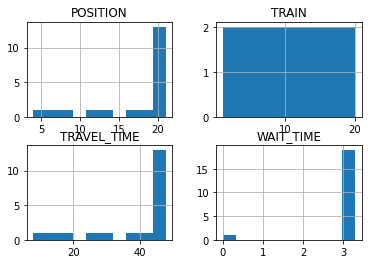

In [193]:
train_summary.hist()

In [194]:
train_summary['TRAVEL_TIME'].mean()

40.067499999999995

### Bar Graph

Time taken by each train in every block is shown using bar graph

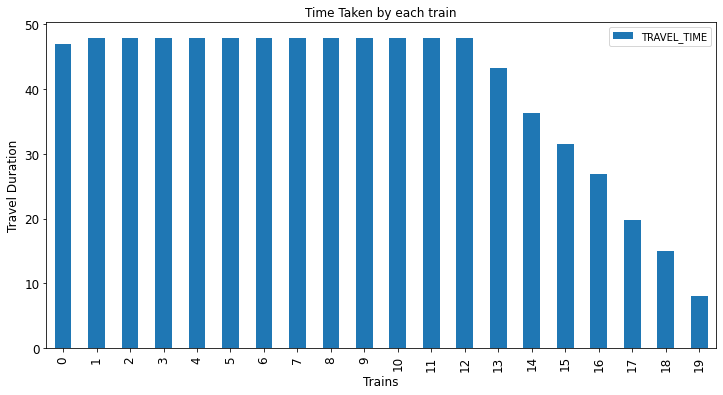

In [195]:
ax = train_summary[['TRAVEL_TIME']].plot(kind='bar', title ="Time Taken by each train", figsize=(12, 6), legend=True, fontsize=12)
ax.set_xlabel("Trains", fontsize=12)
ax.set_ylabel("Travel Duration", fontsize=12)
plt.show()

### Histogram 

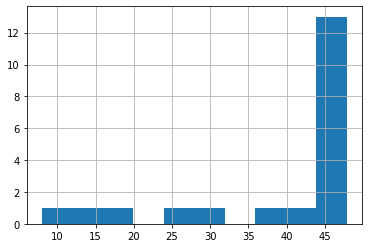

In [198]:
train_summary['TRAVEL_TIME'].hist()

### Optimization

In [196]:

def returnJT(n_train):
    return train_summary['TRAVEL_TIME'][0:n_train].mean()

global test
test = [[ 1.76243515, 1.62728484, 1.53379507, 1.48995384, 1.45814218,
  1.4189883,  1.39397861, 1.37891062, 1.36208892, 1.34684138],
 [ 1.40824573, 1.42553032, 1.40794609, 1.36399272, 1.32766208,
  1.28896544, 1.26302747, 1.24477788, 1.2290161,  1.21296302],
 [ 1.39893615, 1.29098931, 1.38363664, 1.37047181, 1.34113254,
  1.30238022, 1.27674341, 1.26124137, 1.2414579,  1.22748731],
 [ 1.41234336, 1.28146509, 1.2626437,  1.41257031, 1.39299756,
  1.35254565, 1.3288118,  1.31152966, 1.293569,   1.28035892],
 [ 1.42718535, 1.26995045, 1.28287265, 1.29825884, 1.45462442,
  1.42342871, 1.39782319, 1.38089691, 1.36718642, 1.34726236],
 [ 1.44298492, 1.27930999, 1.23366666, 1.30210756, 1.50732976,
  1.49447523, 1.47135817, 1.45820684, 1.43785602, 1.41994126],
 [ 1.45833998, 1.29209213, 1.23356387, 1.3110052,  1.41214098,
  1.57240554, 1.5457894,  1.52966239, 1.51265756, 1.49389733],
 [ 1.4743032,  1.30814848, 1.23928074, 1.23567648, 1.37040229,
  1.64187052, 1.61312586, 1.60092246, 1.58422249, 1.56804154],
 [ 1.48995022, 1.32412621, 1.25008371, 1.23015658, 1.37567555,
  1.70684373, 1.68169122, 1.66348836, 1.64016921, 1.62851679],
 [ 1.50639668, 1.33872472, 1.26189455, 1.2369861,  1.29752348,
  1.74739972, 1.71455359, 1.70529688, 1.69281667, 1.67315445]]



### applying greedy hill climbing 

 x y  f(x, y)
 5 7   47.711
 4 8   47.672
 3 9   47.640
 2 9   47.593
 1 9   47.513
 0 9   47.355


(6, 2, 20, 47.355000000000004)

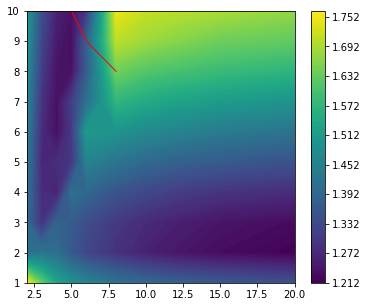

In [197]:

def neighbours(x, y, xmin, xmax, ymin, ymax):
    return [(x + 1, y - 1) if x < xmax and 0 < y else None,
            (x + 1, y) if x < xmax else None,
            (x + 1, y + 1) if x < xmax and y < ymax else None,
            (x, y + 1) if y < ymax else None,
            (x - 1, y + 1) if 0 < x and y < ymax else None,
            (x - 1, y) if 0 < x else None,
            (x - 1, y - 1) if 0 < x and 0 < y else None,
            (x, y - 1) if 0 < y else None]


def Greedy_Hill_Climbing(f , df, var):
    Trains_PH_sort = [2, 3, 4, 5, 6, 8, 10, 12, 15, 20]

    Sig_blocks_sort = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

    Trains_PH_idx = range(len(train_list))
    Sig_blocks_idx = range(len(Sig_blocks_sort))

    x0 = random.choice(Trains_PH_idx)
    y0 = random.choice(Sig_blocks_idx)
    xp = [x0]
    yp = [y0]
    

    fmin = f(Trains_PH_sort[x0])
    


    xmin = 0
    ymin = 0
    xmax = len(Trains_PH_sort) - 1
    ymax = len(Sig_blocks_sort) - 1
    
    

    print(f"{' x'}{' y'}{'f(x, y)':>9s}")
    print(f"{x0:2d}{y0:2d}{fmin:9.3f}")

    while True:
        xi = xp[-1]
        yi = yp[-1]
        fi = fmin
        for xy in neighbours(xi, yi, xmin, xmax, ymin, ymax):
            if xy != None:
                x, y = xy
                ff = returnJT(Trains_PH_sort[x])
                if ff < fi:
                    xi = x
                    yi = y
                    fi = ff
        if fi == fmin:
            break

        xp += [xi]
        yp += [yi]
        fmin = fi
        print(f"{xi:2d}{yi:2d}{fi:9.3f}")
          


    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(6)
    fig.set_figheight(5)

#    print('values', len(Trains_PH_sort), len(Sig_blocks_sort), len(test[1]))
    cs = ax.contourf(Trains_PH_sort, Sig_blocks_sort, test, 100)
    fig.colorbar(cs, ax=ax)

    plt.plot([Trains_PH_sort[x] for x in xp], [Sig_blocks_sort[y] for y in yp], c='red', lw=1)
    return len(xp), Trains_PH_sort[xp[-1]], Trains_PH_sort[yp[-1]], f(Trains_PH_sort[xp[-1]])


Greedy_Hill_Climbing(returnJT, train_summary, 'TRAVEL_TIME')


### Randomized Hill Climbing

 x y  f(x, y)
 5 4   47.711
 4 5   47.672
 3 6   47.640
 2 7   47.593
 1 8   47.513
 0 9   47.355


(6, 2, 20, 47.355000000000004)

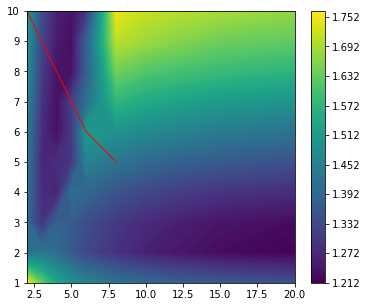

In [202]:
def neighbours_Random(x, y, xmin, xmax, ymin, ymax):
    return ([(x + 1, y - 1)] if x < xmax and 0 < y else []
            ) + ([(x + 1, y)] if x < xmax else []
                 ) + ([(x + 1, y + 1)] if (x < xmax and y < ymax) else []
                      ) + ([(x, y + 1)] if (y < ymax) else []
                           ) + ([(x - 1, y + 1)] if (0 < x and y < ymax) else []
                                ) + ([(x - 1, y)] if (0 < x) else []
                                     ) + ([(x - 1, y - 1)] if (0 < x and 0 < y) else []
                                          ) + ([(x, y - 1)] if (0 < y) else [])


def Randomized_Hill_Climbing(f, df, var):
    
    Trains_PH_sort = [2, 3, 4, 5, 6, 8, 10, 12, 15, 20]

    Sig_blocks_sort = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

    Trains_PH_idx = range(len(train_list))
    Sig_blocks_idx = range(len(Sig_blocks_sort))

    x0 = random.choice(Trains_PH_idx)
    y0 = random.choice(Sig_blocks_idx)
    xp = [x0]
    yp = [y0]
    

    fmin = f(Trains_PH_sort[x0])
    


    xmin = 0
    ymin = 0
    xmax = len(Trains_PH_sort) - 1
    ymax = len(Sig_blocks_sort) - 1
    
    

    print(f"{' x'}{' y'}{'f(x, y)':>9s}")
    print(f"{x0:2d}{y0:2d}{fmin:9.3f}")

    while True:
        xi = xp[-1]
        yi = yp[-1]
        fi = fmin
        for xy in neighbours(xi, yi, xmin, xmax, ymin, ymax):
            if xy != None:
                x, y = xy
                ff = returnJT(Trains_PH_sort[x])
                if ff < fi:
                    xi = x
                    yi = y
                    fi = ff
        if fi == fmin:
            break

        xp += [xi]
        yp += [yi]
        fmin = fi
        print(f"{xi:2d}{yi:2d}{fi:9.3f}")
          
    
    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(6)
    fig.set_figheight(5)

#    print('values', len(Trains_PH_sort), len(Sig_blocks_sort), len(test[1]))
    cs = ax.contourf(Trains_PH_sort, Sig_blocks_sort, test, 100)
    fig.colorbar(cs, ax=ax)

    plt.plot([Trains_PH_sort[x] for x in xp], [Sig_blocks_sort[y] for y in yp], c='red', lw=1)
    return len(xp), Trains_PH_sort[xp[-1]], Trains_PH_sort[yp[-1]], f(Trains_PH_sort[xp[-1]])
          
    


Randomized_Hill_Climbing(returnJT, train_summary, 'TRAVEL_TIME')
